<a href="https://colab.research.google.com/github/spctr01/lightgbm/blob/main/CloudAeye.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

%matplotlib inline
warnings.filterwarnings('ignore')

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn import metrics
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform

**change directory to file location**

In [2]:
cd drive/My Drive

/content/drive/My Drive


In [3]:
#read and look at the data
data = pd.read_csv('consolidated-metrics.csv')
data.head()

,timestamp,apiserver_current_inflight_requests,apiserver_request_latencies_summary,apiserver_response_sizes_sum,apiserver_storage_transformation_latencies_microseconds_sum,aws_cpu_utilization,aws_ec2_cpuutilization_average,aws_ec2_network_out_average,aws_network_out,cgroup_manager_operation_rate,container_cpu_cfs_throttled_seconds_total,container_fs_inodes_free,container_fs_usage_bytes,container_fs_writes_total,container_memory_cache,container_memory_mapped_file,container_memory_rss,container_memory_usage_bytes,container_memory_working_set_bytes,coredns_kubernetes_dns_programming_duration_seconds_count,coredns_kubernetes_dns_programming_duration_seconds_sum,etcd_object_counts,etcd_request_latencies_summary_count,http_request_duration_microseconds,http_response_size_bytes,httpsessions_active,kafka_log_size_growth_rate,kafka_network_receive,kafka_network_transmit,kanban_boards_creation,kanban_tasks_complete_with_200_status,kanban_tasks_get_history,kube_pod_start_time,kube_poddisruptionbudget_status_current_healthy,kube_replicaset_created,kubelet_cgroup_manager_latency_microseconds,kubelet_container_log_filesystem_used_bytes,kubelet_operation_rate,kubelet_pleg_relist_interval_microseconds,kubelet_pleg_relist_latency_microseconds,...,node_filesystem_free_bytes,node_load1,node_load15,node_load5,node_memory_Active_anon_bytes,node_memory_Active_bytes,node_memory_Active_file_bytes,node_memory_AnonHugePages_bytes,node_memory_AnonPages_bytes,node_memory_Buffers_bytes,node_memory_Cached_bytes,node_memory_Committed_AS_bytes,node_memory_Dirty_bytes,node_memory_Inactive_anon_bytes,node_memory_Inactive_bytes,node_memory_Inactive_file_bytes,node_memory_KernelStack_bytes,node_memory_Mapped_bytes,node_memory_MemAvailable_bytes,node_memory_MemFree_bytes,node_memory_SReclaimable_bytes,node_memory_SUnreclaim_bytes,node_memory_Shmem_bytes,node_memory_Slab_bytes,node_memory_Writeback_bytes,node_netstat_Tcp_CurrEstab,node_nf_conntrack_entries,node_procs_blocked,node_procs_running,node_scrape_collector_duration_seconds,node_sockstat_TCP_inuse,node_sockstat_TCP_mem,node_sockstat_TCP_mem_bytes,node_sockstat_TCP_orphan,node_sockstat_TCP_tw,node_sockstat_sockets_used,node_timex_estimated_error_seconds,node_timex_frequency_adjustment_ratio,node_timex_maxerror_seconds,status
0,2020-09-18 21:45:03,0.008333,4.775001e+06,6871.300000,0.025000,13.8,0.000,0.000000,0.000000,0.145833,0.0,155876.292281,4.582444e+08,31.947430,3.290259e+07,6.833672e+06,2.183418e+08,2.930822e+08,2.824967e+08,0.0,0.0,0.308333,7.333333,6.347728,0.066667,0.375000,1220.783333,5724.919214,8424.376927,0.0,0.3750,0.3750,0.0,0.0,0.0,2.716667,1.131008e+06,0.0,84978.795216,1549.886504,...,2.470222e+08,0.017197,0.018250,0.014958,5.852687e+07,6.471299e+07,5.355418e+06,0.0,7.410060e+07,153.600000,9.880303e+06,2.244632e+08,11963.733333,1757.866667,3.394628e+06,3.392870e+06,292044.800000,4.656657e+06,4.891639e+07,1.323989e+07,1.310447e+06,3.931375e+06,6553.600000,7.881847e+06,0.000000,0.033333,15.125000,0.0,0.120833,0.001250,0.054167,2.233333,9147.733333,0.000000,0.983333,25.441667,7.625000e-07,0.025000,0.000291,NORMAL
1,2020-09-18 21:46:03,0.008333,3.862502e+06,7065.713485,0.025000,19.2,0.025,1752.173542,1752.173542,0.145833,0.0,112788.516331,4.584697e+08,26.978072,1.859325e+07,6.970226e+06,2.306738e+08,3.136550e+08,3.100925e+08,0.0,0.0,0.608335,7.358352,186.125180,0.091667,13.237500,752.341667,2623.485430,4151.707333,0.0,0.2250,0.2250,0.0,0.0,0.0,2.016667,1.505963e+06,0.0,76434.145833,1424.675000,...,2.866220e+08,0.018625,0.018750,0.014417,7.601149e+07,8.622403e+07,5.355025e+06,0.0,8.548780e+07,170.666667,9.875763e+06,2.561419e+08,12834.133333,1757.866667,3.390208e+06,3.388450e+06,391031.466667,6.656427e+06,5.041085e+07,1.104294e+07,1.823659e+06,5.218253e+06,12117.333333,1.042432e+07,0.000000,0.029167,13.591667,0.0,0.108333,0.001182,0.050000,2.887500,11827.200000,0.000000,0.666667,25.420833,7.458333e-07,0.025000,0.000365,CPU_BURN_KANBAN_API_GATEWAY
2,2020-09-18 21:47:03,0.008333,3.862502e+06,6675.4

**checking missing values**

In [4]:
print(data.shape)
null_count = data.isnull().sum()
print(null_count[null_count > 1].sort_values(ascending=False))

print('--------column with 1 missing value')
print(null_count[null_count == 1].sum())

print('---status with null value--------')
data['status'].isna().sum()



(4294, 97)
kubelet_pod_worker_duration_bucket       4073
kanban_tasks_get_history                  211
kanban_tasks_complete_with_200_status     211
kafka_log_size_growth_rate                 18
kubelet_volume_stats_used_bytes             5
kubelet_volume_stats_inodes_used            5
kubelet_volume_stats_inodes_free            5
kubelet_volume_stats_available_bytes        5
kafka_network_transmit                      4
kafka_network_receive                       4
mysql_bytes_received                        3
http_response_size_bytes                    3
http_request_duration_microseconds          3
aws_ec2_network_out_average                 2
aws_network_out                             2
kanban_boards_creation                      2
httpsessions_active                         2
mongodb_network_in                          2
mem_free                                    2
aws_ec2_cpuutilization_average              2
dtype: int64
--------column with 1 missing value
67
---status with nu

1

**From above we can see that data has lot of missing values**  
**But loking at domain , type of problem the data solve in real world (cloud data)**  
*we might not always have all the data and some data points may be missing*  
**So choosing a Algorithm that can handle missing values**

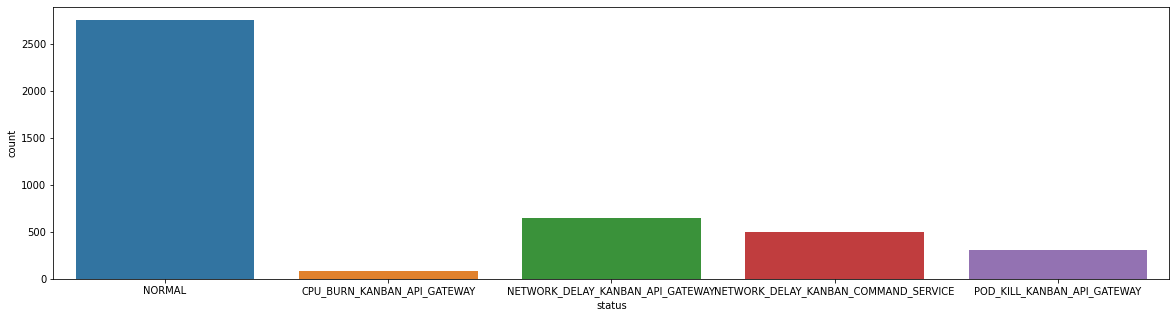

In [5]:
#visualizing the balance of data
fig = plt.figure(figsize=(20,5))
sns.countplot('status', data= data)
plt.show()

In [11]:
#new_data = data.drop(['kubelet_pod_worker_duration_bucket'], axis=1)
#print(new_data.shape)
new_data = data

# As target column "status" has missing value so droping respected row
new_data.dropna(how = 'any', subset=['status'], inplace= True)

# total no of columns that are not categorical
d= new_data._get_numeric_data().columns
print('total non categorical data: ' ,len(d))

#droping timestap column
df = new_data.drop(['timestamp'],axis=1)
df.shape

total non categorical data:  96


(4293, 96)

In [12]:
#encode the categorical varible
encoder = LabelEncoder()
df['status']= encoder.fit_transform(df['status'])

**Spliting data to Train Validation and Test**

In [13]:
x = df.drop('status',axis = 1)
y = df['status']

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size = 0.2)


print('training data \n',y_train.value_counts())
print('test data \n',y_test.value_counts())

training data 
 3    2193
1     525
2     391
4     264
0      61
Name: status, dtype: int64
test data 
 3    564
1    121
2    109
4     46
0     19
Name: status, dtype: int64


In [ ]:
!pip install lightgbm==2.1.1

**Specefying parameters**  
* "early_stopping_rounds": To aviod overfitting  
* "eval_metric" :  evaluation metric  
* "eval_set" :  Set validation data  
* 'verbose':  Print data while training  
* 'categorical_feature':  Categorical columns in data


In [59]:
parameters={"early_stopping_rounds":20, 
            "eval_metric" : 'auc', 
            "eval_set" : [(x_test,y_test)],
            'eval_names': ['valid'],
            'verbose': 100,
            'categorical_feature': 'auto'}

#specifying parameters to tune 
parameter_tuning ={
             'max_depth': sp_randint(10,50),
             'num_leaves': sp_randint(6, 40), 
             'learning_rate ': [0.1,0.01,0.001],
             'min_child_samples': sp_randint(10, 50), 
             'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
             'subsample': sp_uniform(loc=0.2, scale=0.8), 
             'colsample_bytree': sp_uniform(loc=0.4, scale=0.6),
             'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
             'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100],
             }

In [60]:
# creating instance of model and  use RandomSearchCV method to trainf model on tunned parameter 
# and find best model

from lightgbm import LGBMClassifier
model = LGBMClassifier()

find_parameters = RandomizedSearchCV(
                 estimator=model,
                 param_distributions=parameter_tuning, 
                 n_iter=100,
                 scoring='accuracy',
                 cv=5,
                 refit=True,
                 random_state=300,
                 verbose=False)


In [61]:
find_parameters.fit(x_train, y_train, **parameters)
print('Best score : {} with parameters: {} '.format(find_parameters.best_score_, find_parameters.best_params_))

Training until validation scores don't improve for 20 rounds.
Early stopping, best iteration is:
[7]	valid's auc: 0.494486
Training until validation scores don't improve for 20 rounds.
Early stopping, best iteration is:
[1]	valid's auc: 0.5
Training until validation scores don't improve for 20 rounds.
Early stopping, best iteration is:
[1]	valid's auc: 0.5
Training until validation scores don't improve for 20 rounds.
Early stopping, best iteration is:
[1]	valid's auc: 0.5
Training until validation scores don't improve for 20 rounds.
Early stopping, best iteration is:
[3]	valid's auc: 0.508929
Training until validation scores don't improve for 20 rounds.
Early stopping, best iteration is:
[1]	valid's auc: 0.427914
Training until validation scores don't improve for 20 rounds.
Early stopping, best iteration is:
[1]	valid's auc: 0.405639
Training until validation scores don't improve for 20 rounds.
Early stopping, best iteration is:
[1]	valid's auc: 0.350595
Training until validation score

In [62]:
print('Best score / Accuracy:',find_parameters.best_score_ *100)
print(' With parameters:  ')
find_parameters.best_params_

Best score / Accuracy: 89.02173221128751
 With parameters:  


{'colsample_bytree': 0.4791041724988438,
 'learning_rate ': 0.001,
 'max_depth': 38,
 'min_child_samples': 21,
 'min_child_weight': 1e-05,
 'num_leaves': 27,
 'reg_alpha': 0,
 'reg_lambda': 0.1,
 'subsample': 0.6848000463059792}

# Accuracy 89.28